In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


In [3]:
file_path = "./datasets/GOOGL.csv"
df = pd.read_csv(file_path, parse_dates=[0])
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600
...,...,...,...,...,...,...,...
248,2021-04-21,2272.050049,2280.000000,2244.820068,2278.350098,2278.350098,1160200
249,2021-04-22,2275.399902,2288.879883,2240.320068,2252.520020,2252.520020,1207300
250,2021-04-23,2267.000000,2306.120117,2261.250000,2299.929932,2299.929932,1453300
251,2021-04-26,2304.520020,2324.530029,2297.320068,2309.929932,2309.929932,1595200


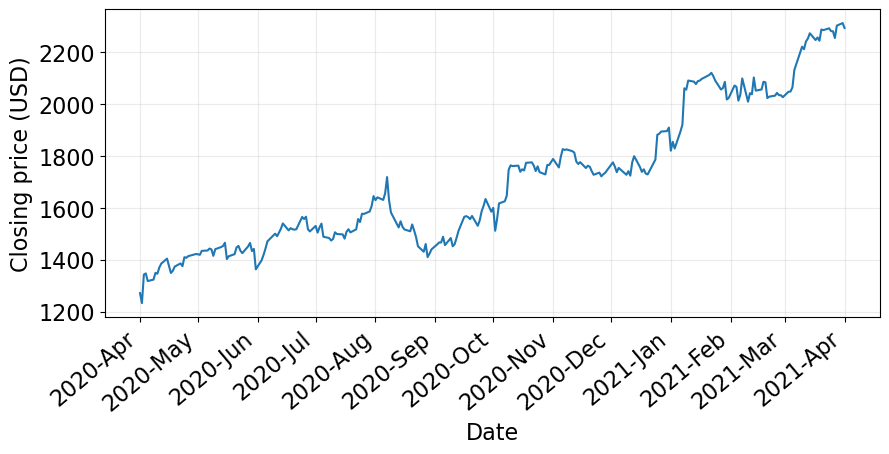

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))

# x_year = pd.DatetimeIndex(df["Date"]).month
ax.plot(df["Date"], df["Close"])

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(interval=1, bymonthday=27)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Closing price (USD)")

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)


## 3.1 The random walk process

A random walk model

$$
  y_{t} = C + y_{t-1} + \epsilon_t
$$

$y_t$ is the value at the present time $t$, $C$ is a constant,
$t_{t-1}$ is the value at the previous timestep $t-1$, 
and $\epsilon_t$ is a random number

### Generate random walk

In [5]:
seed = 20230822                       # set the random seed
rng = np.random.default_rng(seed)     # create Pseudo Random Nuber Generator
                                      # object
steps = rng.normal(size=1000)   # generate 1,000 random number
                                # from a normal distribution with
                                # a mean of 0 and a variance of 1.
steps[0] = 0            # Initialize the first value of the series to 0

# Calculate the cumulative sum of errors for each timestep
# in the simulated process
random_walk = np.cumsum(steps)
random_walk[:10]

array([ 0.        , -1.08399338, -1.11448859, -0.70430056, -0.04471421,
        1.67154292,  2.08900479,  2.06765211,  2.32811894,  4.05651038])

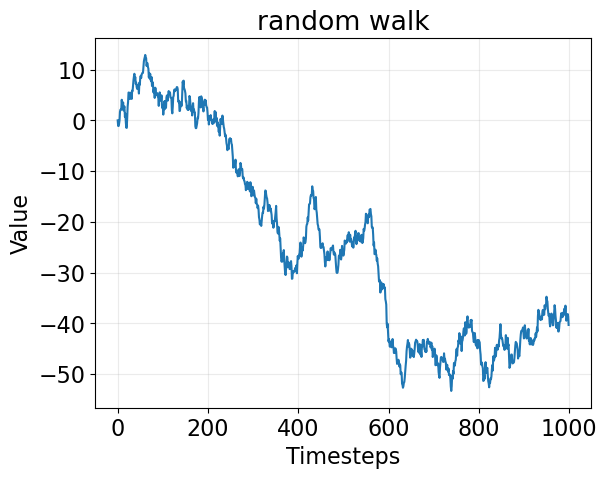

In [27]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.set_title("random walk")
ax.grid("on")

plt.show(fig)

## 3.2 Identifying a random walk

**Random walk**   
A random walk is a series whose first difference is stationary
and uncorrelated. This means that the process moves completely
at random.

**Stationarity**    
A stationary process is one whose statistical properties
do not change over time.    
A times series is said to be stationary if its mean, variance,
and autocorrelation do not change over time.

Some models that apply to stationary time series
- Moving average, $\text{MA}(q)$
- Autoregressive model, $\text{AR}(p)$
- Moving average + Autoregressive model, $\text{ARMA}(p,q)$

Non-stationary time series models
- Autoregressive integrated moving average, 
  $\text{ARIMA}(p, d, q)$
- Seasonal ARIMA, $\text{SARIMA}(p, d, q)(P, D, Q)_m$
- SARIMA with external variables, $\text{SARIMAX}$


Step-by-step to identify a random walk

<img src="./figures/identify-stationary.drawio.png" width=600>

**Transformation in time series forecasting**    
A transformation is a mathematical operation applied to a time
series in order to make it stationary.

Differencing is a transformation that calculates the change
from one timestep to another. This transformation is useful
for stabilizing the mean.

Applying a log function to the series can stabilize its variance.


**Augmented Dickey-Fuller (ADF) test**    
The augmented Dickey-Fuller (ADF) test helps us determine if 
a time series is stationary by testing for the presence of 
a unit root. If a unit root is present, the time series
is not stationary.

The null hypothesis states that t a unit root is present, 
meaning that our time series is not stationary.

General expression of times series $y_t$ that only depends
on its past values $y_{t-1}$ subject to a cofficient $\alpha_1$, 
a constant $C$, and whit noise $\epsilon_t$.

$$
  y_t = C + \alpha_1 y_{t-1} + \epsilon_t
$$

Here, $\alpha_1$ is also called the root of the time series.

In this general expression, the time series will be stationary
only if the root lies withing the unit circle. Therefore, its
value must be between $-1$ and $1$. Otherwise the series
is non-stationary.

Verifying the above statements.    
We generate two process:

$$
\begin{gather*}
  y_t = 0.5 y_{t-1} + \epsilon_t,   \\
  y_t = y_{t-1} + \epsilon_t
\end{gather*}
$$


In [7]:
def simulate_process(is_stationary: bool, seed: int=20230822) -> np.array:
  rng = np.random.default_rng(seed)
  N_timestep = 400
  process = np.empty(N_timestep)

  if is_stationary:
    alpha = 0.5
  else:
    alpha = 1.

  process[0]
  for i in range(N_timestep-1):
    process[i+1] = alpha*process[i] + rng.normal()

  return process

In [8]:
seed = 20230822 
stationary = simulate_process(True, seed)
non_stationary = simulate_process(False, seed)

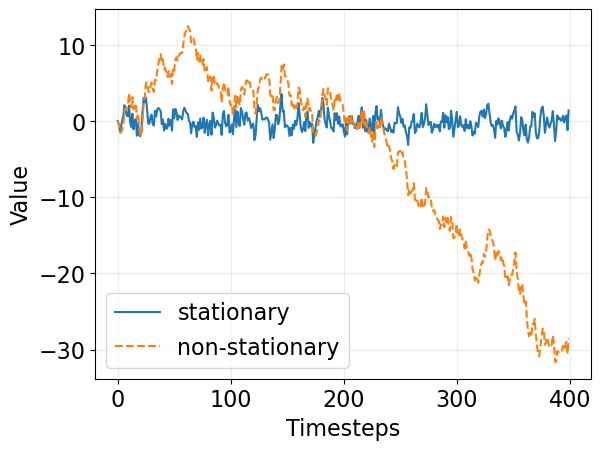

In [9]:
fig, ax = plt.subplots()

ax.plot(stationary, linestyle="-", label="stationary")
ax.plot(non_stationary, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)

Compute mean for those two processes

In [10]:
def mean_over_time(process: np.array) -> np.array:
  mean_func = []
  for i in range(len(process)):
    mean_func.append(np.mean(process[:i+1]))

  return np.array(mean_func)

In [11]:
stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

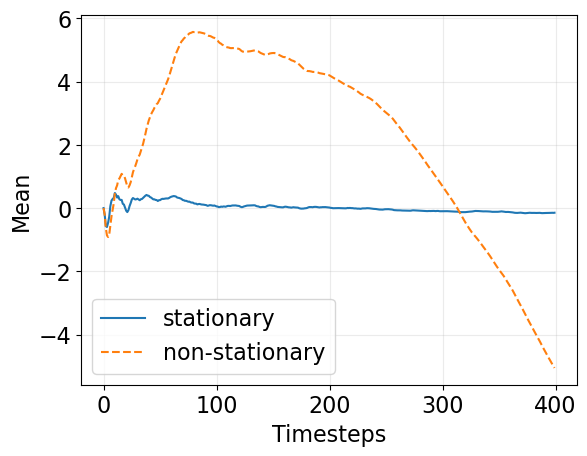

In [12]:
fig, ax = plt.subplots()

ax.plot(stationary_mean, linestyle="-", label="stationary")
ax.plot(non_stationary_mean, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Mean")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)


Compute variance for those two processes

In [13]:
def var_over_time(process: np.array) -> np.array:
  var_func = []
  for i in range(len(process)):
    var_func.append(np.var(process[:i+1]))

  return np.array(var_func)

In [14]:
stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

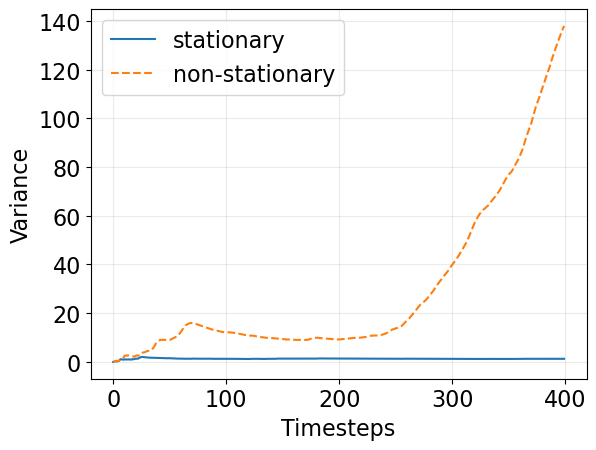

In [118]:
fig, ax = plt.subplots()

ax.plot(stationary_var, linestyle="-", label="stationary")
ax.plot(non_stationary_var, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Variance")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)

**Autocorrelation function**   
The autocorrelation function (ACF) measures the linear relationship between lagged
values of a time series.

In other words, it measures the correlation of the time series with itself.

Using `statsmodels` library, we can compute ADF statistic and plot autocorrelation
function

In [17]:
ADF_result = adfuller(random_walk)
print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -1.1026916329000345
p-value: 0.7139973202431394


The ADF statistic is not a large negative number with a $p$-value greater than 0.05,
we cannot reject the null hypothesis stating that our time series is not
stationary.

We can further support our conclusion by plotting the ACF (autocorrelation function)

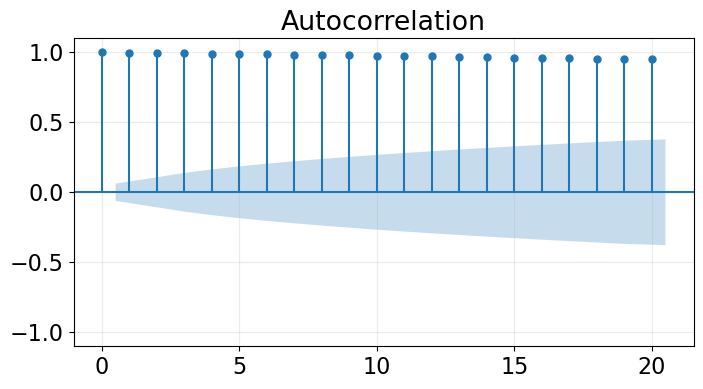

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))

fig = plot_acf(random_walk, lags=20, ax=ax)

ax.set_ylim([-1.1, 1.1])
ax.grid('on')
plt.show(fig)

Let us compute the ADF statistic and plot ACF for the first difference of
`random_walk`

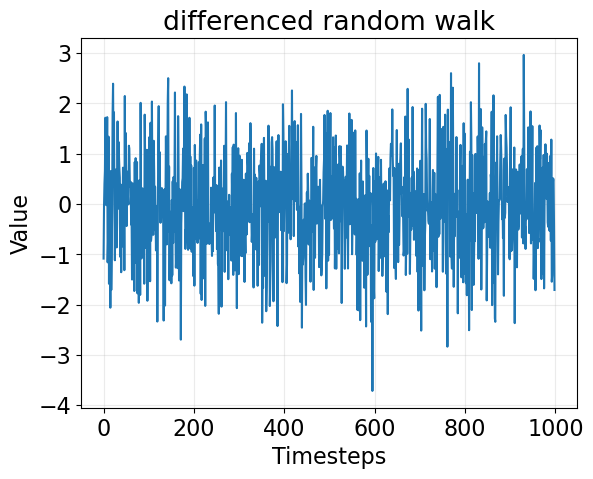

In [28]:
diff_random_walk = np.diff(random_walk, n=1)

fig, ax = plt.subplots()

ax.plot(diff_random_walk)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.set_title("differenced random walk")
ax.grid("on")

plt.show(fig)

In [25]:
ADF_result = adfuller(diff_random_walk)
print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -32.6328358802053
p-value: 0.0


This time the ADF statistic is a large negative number, and the $p$-value is 
less than 0.05. Therefore, we reject the null hypothesis, and we
can say that this process has no unit root is thus stationary. With further
plot of ACF, we make sure that the differenced random walk is stationary.

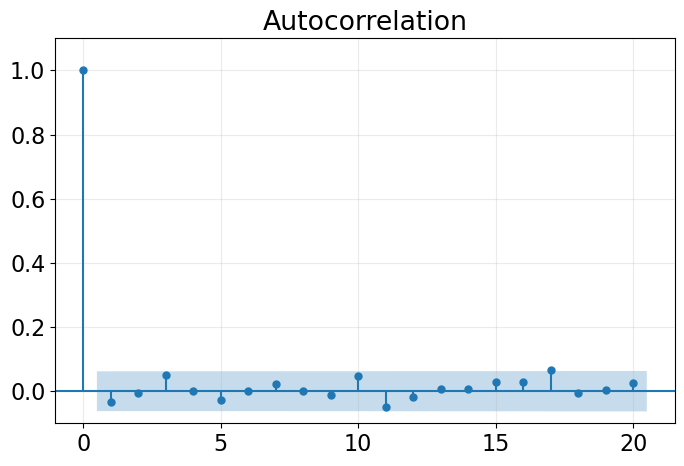

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

fig = plot_acf(diff_random_walk, lags=20, ax=ax)

ax.set_ylim([-.1, 1.1])
ax.grid("on")

plt.show(fig)

Next we test that if GOOGL is a random walk  or not.
First we print out the `df` and plot again the GOOGL closing price.


In [33]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600
...,...,...,...,...,...,...,...
248,2021-04-21,2272.050049,2280.000000,2244.820068,2278.350098,2278.350098,1160200
249,2021-04-22,2275.399902,2288.879883,2240.320068,2252.520020,2252.520020,1207300
250,2021-04-23,2267.000000,2306.120117,2261.250000,2299.929932,2299.929932,1453300
251,2021-04-26,2304.520020,2324.530029,2297.320068,2309.929932,2309.929932,1595200


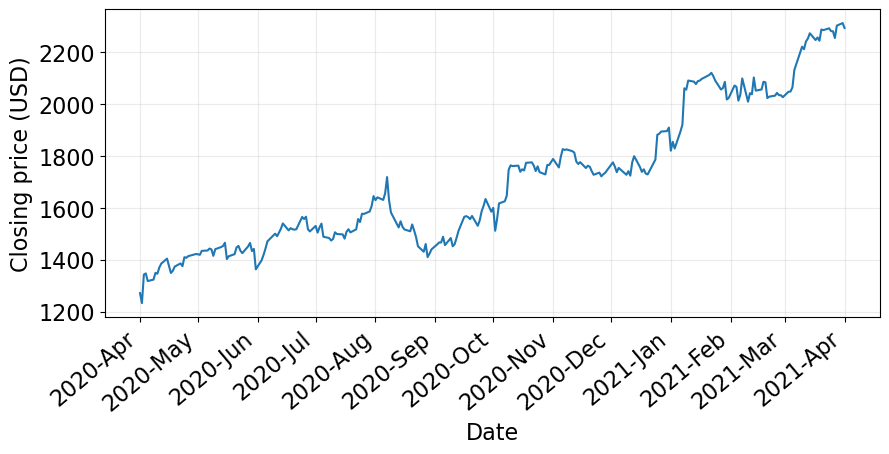

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))

# x_year = pd.DatetimeIndex(df["Date"]).month
ax.plot(df["Date"], df["Close"])

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(interval=1, bymonthday=27)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Closing price (USD)")

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)


Compute ADF statistic for GOOGL

In [35]:
GOOGL_ADF_result = adfuller(df["Close"])
print(f"ADF statistic: {GOOGL_ADF_result[0]}")
print(f"p-value: {GOOGL_ADF_result[1]}")

ADF statistic: 0.16025048664771274
p-value: 0.9699419435913057


The ADF statistic is not a large negative number which is supported
by the $p$-value that is still larger than 0.05.

How about its first difference ($y_{t+1}-y_{t}$)? 

In [37]:
diff_close = np.diff(df["Close"], n=1)

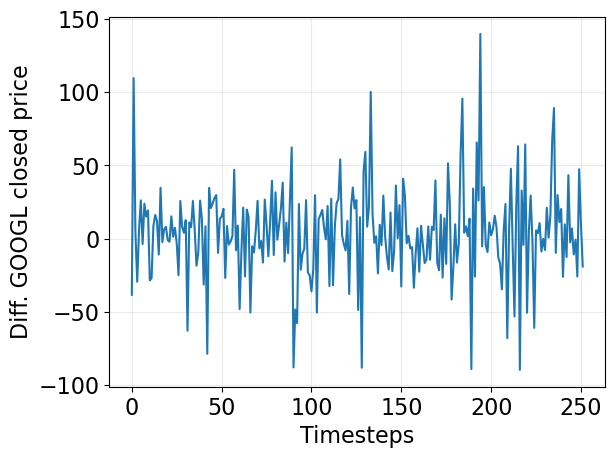

In [41]:
fig, ax = plt.subplots()

ax.plot(diff_close)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Diff. GOOGL closed price")
ax.grid("on")

plt.show(fig)

Next, we can run ADF test on the differenced data:

In [42]:
GOOGL_diff_ADF_result = adfuller(diff_close)
print(f"ADF statistic: {GOOGL_diff_ADF_result[0]}")
print(f"p-value: {GOOGL_diff_ADF_result[1]}")

ADF statistic: -5.303439704295235
p-value: 5.3865309614545585e-06


This gives an ADF statistic of $-5.3$ and a $p$-value smaller than $0.05$,
meaning that we have a stationary process.

Let us plot ACF to see the correlation between each lags.

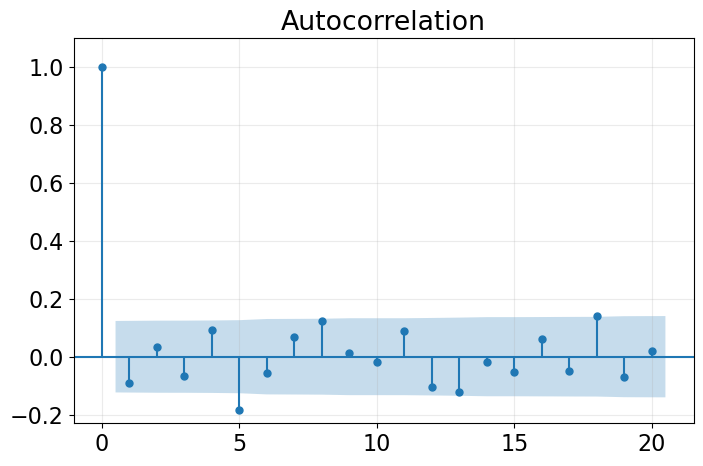

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

fig = plot_acf(diff_close, lags=20, ax=ax)

ax.set_ylim([-.23, 1.1])
ax.grid("on")

plt.show(fig)

In the figure above, we do not see any significant coefficients, 
except at lags 5 and 18. This situation can arise
sometimes, and it is due to chance only. In such a situation, 
we can safely assume that the coefficients at lags 5 and 18 are not
significant, because we do not have consecutive coefficients.
It just happened by chance that the differenced values are slighly correlated 
with the ones at lags 5 and 18

Therefore, we can conclude that the closing price of GOOGL can be approximated
by a random walk process. Takit the first difference makes the series 
stationary, and its ACF plot shows no autocorrelation, meaning that it is
purely random.



## 3.3 Forecasting a random walk

We have prepare our dataset from `random_walk` and now we split them
into two part: `train` and `test`

In [54]:
df_random_walk = pd.DataFrame({"value": random_walk})

# Do not forget to put copy. In the textbook the author use splitting without .copy()
train = df_random_walk[:800].copy()
test = df_random_walk[800:].copy()

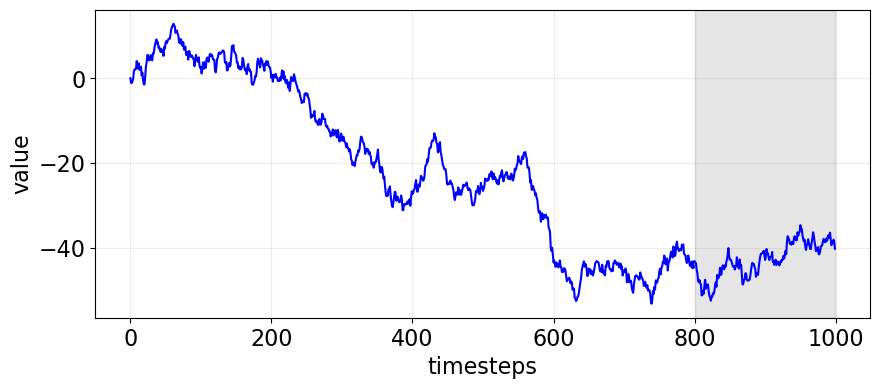

In [69]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(train["value"], "b-")
ax.plot(test["value"], "b-")

# add forecast area (index of `test`)
ax.axvspan(800, 999,
  color="#808080", alpha=0.2
)

ax.grid("on")
ax.set_xlabel("timesteps")
ax.set_ylabel("value")

plt.show(fig)



We perform three kinds of forecasting: mean, last value and drift method

In [58]:
mean_train_random_walk = np.mean(train["value"])
test["pred_mean"] = mean_train_random_walk

test.head()

,value,pred_mean
800,-43.271249,-19.858622
801,-43.536536,-19.858622
802,-43.729512,-19.858622
803,-45.303077,-19.858622
804,-46.111275,-19.858622


In [61]:
last_value = train.iloc[-1]["value"]
test["pred_last"] = last_value

test.head()

,value,pred_mean,pred_last
800,-43.271249,-19.858622,-44.675694
801,-43.536536,-19.858622,-44.675694
802,-43.729512,-19.858622,-44.675694
803,-45.303077,-19.858622,-44.675694
804,-46.111275,-19.858622,-44.675694


In the last week, we have not covered it yet. The model for the drift method is

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$
where $\text{drift}$ is formulated as

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

In [62]:
h_x = 800 - 1
h_y = last_value - train.iloc[0]["value"]
drift = h_y / h_x
print(f"drift = {drift}")

drift = -0.05591451103564848


In [64]:
x_vals = np.arange(800, 1000, 1)   # x data for test
pred_drift = drift * x_vals
test["pred_drift"] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
800,-43.271249,-19.858622,-44.675694,-44.731609
801,-43.536536,-19.858622,-44.675694,-44.787523
802,-43.729512,-19.858622,-44.675694,-44.843438
803,-45.303077,-19.858622,-44.675694,-44.899352
804,-46.111275,-19.858622,-44.675694,-44.955267


Comparing all three models

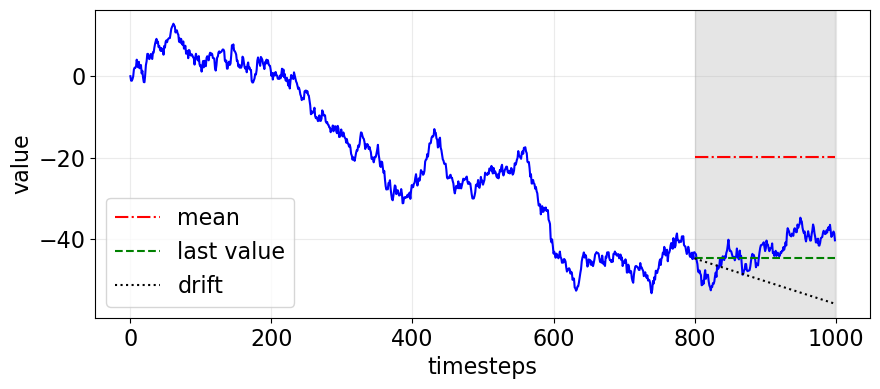

In [70]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(train["value"], "b-")
ax.plot(test["value"], "b-")

# forecasting
ax.plot(test["pred_mean"], "r-.", label="mean")
ax.plot(test["pred_last"], "g--", label="last value")
ax.plot(test["pred_drift"], "k:", label="drift")

# add forecast area (index of `test`)
ax.axvspan(800, 999,
  color="#808080", alpha=0.2
)

ax.grid("on")
ax.set_xlabel("timesteps")
ax.set_ylabel("value")

ax.legend(loc="best")

plt.show(fig)



To measure how good is our model, we can use MAPE. Unfortunately our data
contains 0 then instead using MAPE, we can use MSE (Mean Squared Error).

In [74]:
mse_pred_mean = mean_squared_error(test["value"], test["pred_mean"])
mse_pred_last = mean_squared_error(test["value"], test["pred_last"])
mse_pred_drift = mean_squared_error(test["value"], test["pred_drift"])

print(f"MSE mean: {mse_pred_mean}")
print(f"MSE last: {mse_pred_last}")
print(f"MSE drif: {mse_pred_drift}")

MSE mean: 549.9255036412255
MSE last: 19.876267760827922
MSE drif: 103.5944661836943


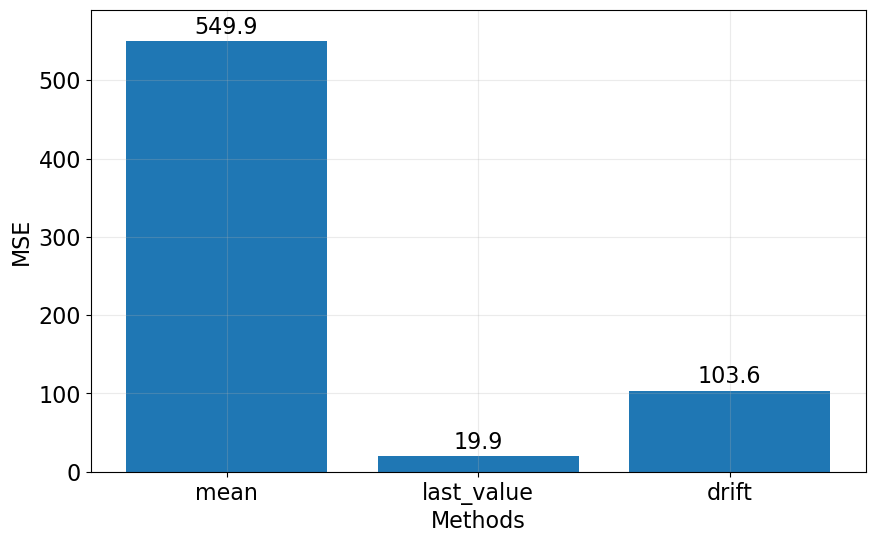

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 590])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+10, s=f"{val:.1f}", ha="center")

plt.show(fig)

The last model that we want to review, and sometimes misused by some people
to give a good impression of the model, is forecasting for single time
step (the horizon is one time step further).

In [82]:
df_shift_random_walk = df_random_walk.shift(periods=1)
df_shift_random_walk.head()

,value
0,NaN
1,0.000000
2,-1.083993
3,-1.114489
4,-0.704301


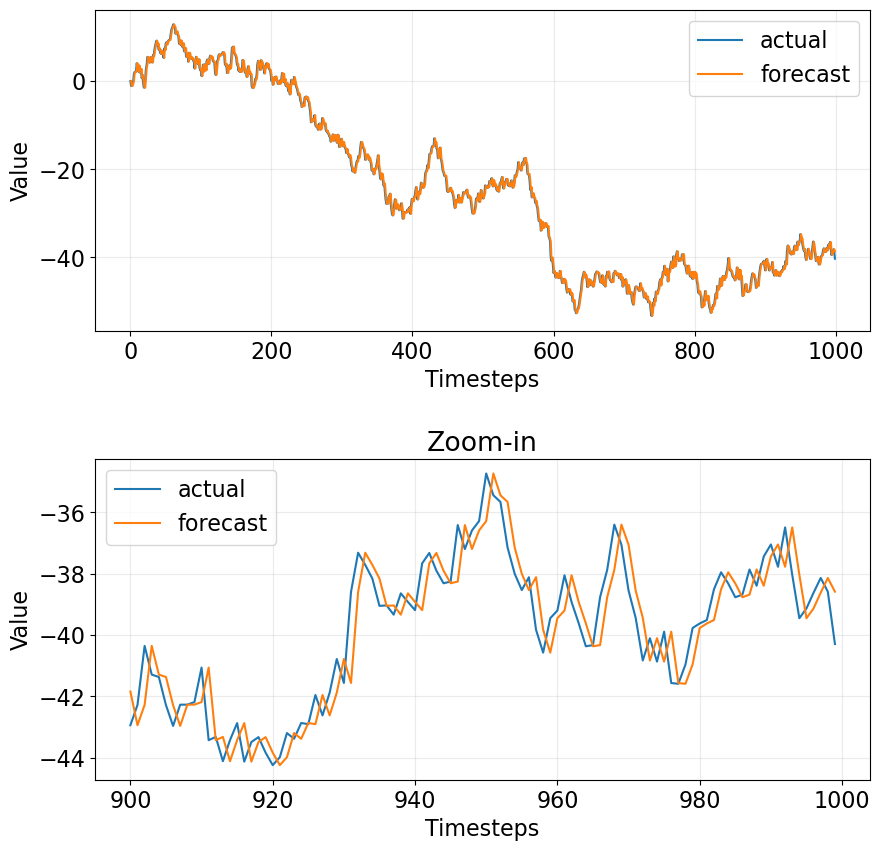

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(df_random_walk, label="actual")
axes[0].plot(df_shift_random_walk, label="forecast")

axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Value")
axes[0].grid("on")
axes[0].legend(loc="best")

# zoom in
axes[1].plot(df_random_walk[900:], label="actual")
axes[1].plot(df_shift_random_walk[900:], label="forecast")

axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Value")
axes[1].set_title("Zoom-in")
axes[1].grid("on")
axes[1].legend(loc="best")

plt.subplots_adjust(hspace=.4)
plt.show(fig)

MSE yields a smaller error compared to the last three methods

In [108]:
mse_one_step = mean_squared_error(test["value"], df_shift_random_walk[800:])
print(f"MSE one step: {mse_one_step}")

MSE one step: 1.034946180411229


Experimenting with xticklabels of `mdates` with interval in month.
I would like to create a xticklabels such that for each month
there is a year label but only one occurrence during 12 months.

In [42]:
x_year = pd.DatetimeIndex(df["Date"]).year
x_month = pd.DatetimeIndex(df["Date"]).month
x_year_month = [(y, m) for y, m in zip(x_year, x_month)]
x_year_month = list(dict.fromkeys(x_year_month))
x_year_month = [""]

def fix_year_month_label(fig, ax):
  # We need to draw the canvas, otherwise the labels won't
  # be positioned and won't have values yet.
  fig.canvas.draw()

  labels = [item.get_text() for item in ax.get_xticklabels()]
  labels_fix = labels.copy()
  year_flag = labels[0].split("-")[0]
  for j, item in enumerate(labels[1:]):
    current_year_flag = item.split("-")[0]
    if current_year_flag == year_flag:
      # print(j, len(labels_fix), item)
      labels_fix[j+1] = item.split("-")[1]
    else:
      year_flag = current_year_flag

  return labels_fix
